# Intro to GNNs using Pytorch Geometric
July 2022

By: Mariel Pettee (LBNL), with portions adapted from the Pytorch Geometric documentation (https://pytorch-geometric.readthedocs.io/)


In [1]:
import pandas as pd
import numpy as np
import glob
import time
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
import networkx as nx # for visualizing graphs
from sklearn.preprocessing import StandardScaler

import torch_geometric.nn as pyg_nn
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch.optim as optim
from copy import deepcopy
from torch_geometric.nn import GINConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import TUDataset
from sklearn.metrics import *
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch

/clusterfs/ml4hep/mpettee/miniconda3/envs/pytorch_geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Simple example:

Let's start very simply... a graph with 3 nodes (0,1, and 2) and two edges connecting nodes 0&harr;1 and 1&harr;2. 
Note that the `edge_index` object has two arrays: one of starting nodes and one of ending nodes for each edge.

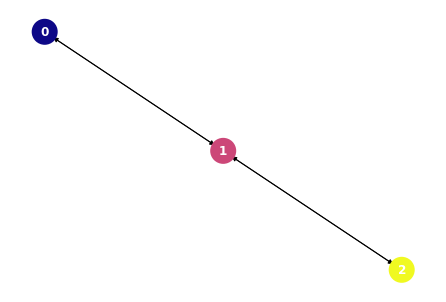

In [2]:
### Define node features 
x = torch.tensor([[-1], # node 0
                  [0],  # node 1
                  [1]], # node 2
                 dtype=torch.float)

### Define two (bidirectional) edges between nodes [0,1] and between nodes [1,2]:
edge_index = torch.tensor([[0, 1, 1, 2], # starting node of each edge
                           [1, 0, 2, 1]  # ending node of each edge
                          ], dtype=torch.long)

### Put it all together into a graph structure
data = Data(x=x, edge_index=edge_index)

### Visualize the graph
plt.figure() 
nx.draw(to_networkx(data), 
        cmap='plasma', 
        node_color = np.arange(data.num_nodes),
        with_labels=True,
        font_weight='bold',
        font_color='white',
        node_size=400, linewidths=6)

In [3]:
print("Graph nodes have {} node feature(s) each.".format(data.num_node_features))
print("Graph has {} nodes and {} edges.".format(data.num_nodes, data.num_edges)) # each direction of the edge counts as an edge
print("Is the graph undirected?: {}".format(data.is_undirected())) # this means the edges are bi-directional (connect both nodes in both directions)

Graph nodes have 1 node feature(s) each.
Graph has 3 nodes and 4 edges.
Is the graph undirected?: True


### &rarr; Before moving onto the next section:
Modify the code above to create two additional graph structures:
1. A directed graph with connections from 0&rarr;1, 1&rarr;2, 2&rarr;0
2. A graph with 4 nodes with only self-connections (0&harr;0, 1&harr;1, 2&harr;2, 3&harr;3) 

# Load the ENZYMES dataset & visualize it

Let's work with a slightly more interesting toy dataset: proteins! 

In [4]:
### Load the dataset
from torch_geometric.datasets import TUDataset
enzymes = TUDataset(root='/tmp/ENZYMES', name='ENZYMES') 
print("Dataset has {} entries, with {} classes and {} node features.".format(len(enzymes), 
                                                                             enzymes.num_classes, 
                                                                             enzymes.num_node_features))

print("First entry has {:,} nodes and {:,} edges.".format(enzymes[0].num_nodes, enzymes[0].num_edges))
print("Is the graph undirected?: {}".format(enzymes[0].is_undirected()))

### Now convert the dataset into graphs
graphs = GraphDataset.pyg_to_graphs(enzymes) 
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
print("Dataset has {} classes".format(dataset.num_graph_labels))
print("Dataset has {} node features".format(dataset.num_node_features))

Dataset has 600 entries, with 6 classes and 3 node features.
First entry has 37 nodes and 168 edges.
Is the graph undirected?: True
Dataset has 6 classes
Dataset has 3 node features


Refresh the cell below a few times to see multiple ways of visualizing one particular protein:

This protein belongs to class 3.


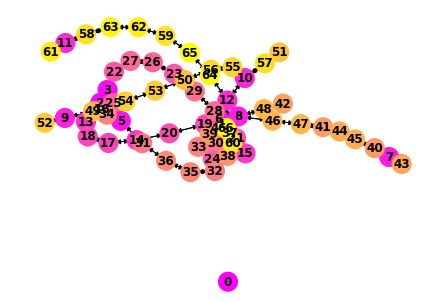

In [5]:
### Visualize one of these proteins 
plt.figure() 
print("This protein belongs to class {}.".format(enzymes[500].y[0])) # overall class of this protein
graph = enzymes[500]
nx.draw(to_networkx(graph), 
        cmap='spring', 
        with_labels=True,
        font_weight='bold',
        node_color = np.arange(graph.num_nodes),
        node_size=200, linewidths=6)

Let's visualize a handful of these proteins from various classes at once, too:

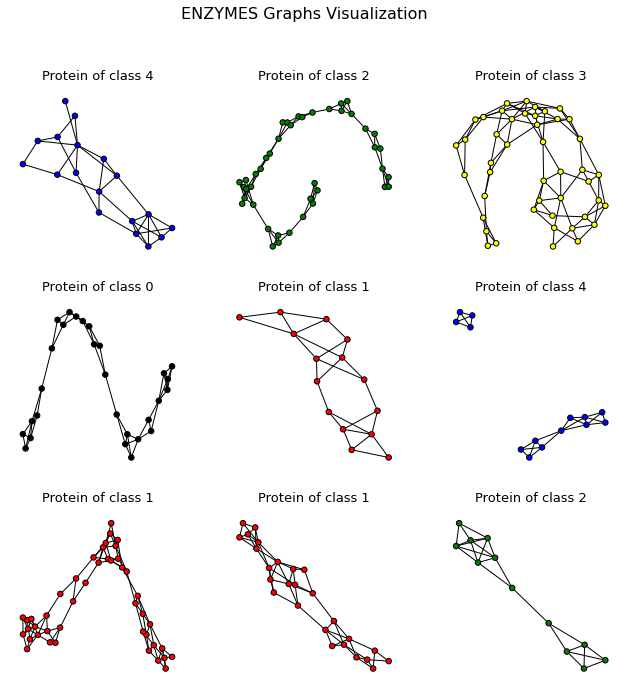

In [6]:
def visualize(dataset):
    color_mapping = {
        0 : 'black',
        1 : 'red',
        2 : 'green',
        3 : 'yellow',
        4 : 'blue',
        5 : 'purple',
    }
    num_graphs_i = 3
    num_graphs_j = 3
    fig, ax = plt.subplots(num_graphs_i, num_graphs_j, figsize=(11, 11))
    fig.suptitle("ENZYMES Graphs Visualization", fontsize=16)
    indices = np.random.choice(np.arange(0, len(dataset)), size=9, replace=False)
    indices = indices.reshape(3, 3)
    for i in range(num_graphs_i):
        for j in range(num_graphs_j):
            index = int(indices[i, j])
            G = dataset[index].G
            label = dataset[index].graph_label.item()
            pos = nx.spring_layout(G, seed=1)
            colors = [color_mapping[label]] * dataset[index].num_nodes
            nodes = nx.draw_networkx_nodes(G, pos=pos, cmap=plt.get_cmap('coolwarm'), \
                node_size=30, ax=ax[(i, j)], node_color=colors)
            nodes.set_edgecolor('black')
            nx.draw_networkx_edges(G, pos=pos, ax=ax[(i, j)])
            ax[(i, j)].set_title("Protein of class {}".format(label), fontsize=13)
            ax[(i, j)].set_axis_off()
    plt.show()
visualize(dataset)

Let's build a basic GNN for graph classification. Given an input graph, we want our GNN to output which class of protein it belongs to. 

In [7]:
class GNNClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GNNClassifier, self).__init__()
        self.num_layers = args["num_layers"]
        self.pre_mp = nn.Linear(input_size, hidden_size) ### "mp" = "message passing"
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        
        ### First up: some dense layers
        for l in range(self.num_layers):
            layer = Sequential(
                Linear(hidden_size, hidden_size), 
                nn.LeakyReLU(), 
                Linear(hidden_size, hidden_size)
            )
            ### Then: the graph convolution layer, i.e. the message-passing step
            self.convs.append(GINConv(layer)) 
            self.bns.append(nn.BatchNorm1d(hidden_size)) 
        ### Finally: some more dense layers
        self.post_mp = Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch
        x = self.pre_mp(x)
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index) ### graph convolutions
            x = self.bns[i](x) ### batch norms
        x = self.convs[-1](x, edge_index) ### Final graph convolution doesn't need a batch norm
        x = pyg_nn.global_add_pool(x, batch) ### Take the sum of all the node features to get a graph-level output
        x = self.post_mp(x) ### Feed global feature through one final dense layer
        x = F.log_softmax(x, dim=1) ### Use softmax activation function for multi-class classification
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label) ### Negative log likelihood loss

Define train & test functions:

In [8]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, device="cpu"):
    model = GNNClassifier(num_node_features, args["hidden_size"], num_classes, args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    best_model = None
    max_val = -1
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        num_graphs = 0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.graph_label
            loss = model.loss(pred, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            num_graphs += batch.num_graphs
        total_loss /= num_graphs
        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        if val_acc > max_val:
            max_val = val_acc
            best_model = deepcopy(model)
        test_acc = test(test_loader, model, device)
        log = "Epoch {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}"
        print(log.format(epoch + 1, train_acc, val_acc, test_acc, total_loss))
    return best_model

def test(loader, model, device='cuda'):
    model.eval()
    correct = 0
    num_graphs = 0
    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            label = batch.graph_label
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
    return correct / num_graphs

Define hyperparameters for training: 

In [40]:
args = {
    "device" : 'cpu', # we don't need GPUs for this
    "hidden_size" : 50,
    "epochs" : 10,
    "lr" : 0.001,
    "num_layers": 3,
    "dataset" : "ENZYMES",
    "batch_size": 32,
}

### Define the train/val/test datasets
pyg_dataset = TUDataset('./tmp/enzymes', args["dataset"])
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1]) # 80% for training, 10% validation, 10% test
num_node_features = dataset.num_node_features
num_classes = dataset.num_graph_labels

### Load batches of graphs at a time
train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])

Now train!

In [41]:
best_model = train(train_loader, val_loader, test_loader, args, 
                   num_node_features, num_classes, args["device"])
train_acc = test(train_loader, best_model, args["device"])
val_acc = test(val_loader, best_model, args["device"])
test_acc = test(test_loader, best_model, args["device"])
log = "Best model: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}"
print(log.format(train_acc, val_acc, test_acc))

Epoch 1: Train: 0.1875, Validation: 0.1833. Test: 0.1500, Loss: 3.2919
Epoch 2: Train: 0.2604, Validation: 0.2000. Test: 0.1333, Loss: 2.2177
Epoch 3: Train: 0.3000, Validation: 0.2167. Test: 0.2000, Loss: 1.8028
Epoch 4: Train: 0.2792, Validation: 0.2167. Test: 0.2667, Loss: 1.6778
Epoch 5: Train: 0.3187, Validation: 0.2500. Test: 0.2000, Loss: 1.7049
Epoch 6: Train: 0.3312, Validation: 0.2500. Test: 0.2667, Loss: 1.6763
Epoch 7: Train: 0.3521, Validation: 0.2500. Test: 0.2167, Loss: 1.6046
Epoch 8: Train: 0.3375, Validation: 0.2333. Test: 0.2167, Loss: 1.7385
Epoch 9: Train: 0.4000, Validation: 0.3500. Test: 0.2500, Loss: 1.6773
Epoch 10: Train: 0.4167, Validation: 0.3333. Test: 0.2833, Loss: 1.6149
Best model: Train: 0.4000, Validation: 0.3500. Test: 0.2500


Now let's evalute the performance of the model on the test set:

In [42]:
def test_with_printouts(loader, model, device='cuda'): # with printouts
    model.eval()
    correct = 0
    num_graphs = 0
    batch_num = 0
    for batch in loader:
        print("====== BATCH {} ======".format(batch_num))
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            print("Predicted labels:", pred)
            label = batch.graph_label
            print("True labels:", label)
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
        batch_num += 1
        print("Total graphs in batch:", batch.num_graphs)
        print("Number correctly predicted:", pred.eq(label).sum().item())
        print("Accuracy = {:.2f}%".format(100*pred.eq(label).sum().item()/batch.num_graphs))
    print("\nOut of all {} test graphs, {} predictions were correct.".format(num_graphs, correct))
    print("Total accuracy = {:.2f}%".format(100*correct/num_graphs))       
    return correct / num_graphs

In [43]:
test_acc = test_with_printouts(test_loader, best_model, args["device"])

====== BATCH 0 ======
Predicted labels: tensor([5, 1, 0, 5, 2, 1, 1, 5, 5, 2, 0, 1, 3, 1, 3, 5, 1, 1, 1, 5, 2, 3, 5, 0,
        3, 1, 1, 3, 4, 5, 0, 3])
True labels: tensor([4, 4, 1, 2, 2, 1, 3, 1, 2, 2, 0, 5, 5, 0, 3, 5, 3, 1, 0, 5, 2, 2, 3, 2,
        0, 5, 1, 5, 1, 3, 1, 1])
Total graphs in batch: 32
Number correctly predicted: 10
Accuracy = 31.25%
====== BATCH 1 ======
Predicted labels: tensor([3, 1, 3, 1, 1, 4, 5, 1, 2, 1, 5, 4, 1, 2, 1, 5, 5, 3, 5, 3, 3, 2, 5, 5,
        1, 3, 5, 5])
True labels: tensor([4, 3, 4, 1, 2, 0, 0, 0, 1, 0, 0, 0, 4, 1, 0, 4, 2, 3, 0, 0, 2, 2, 3, 4,
        1, 3, 4, 3])
Total graphs in batch: 28
Number correctly predicted: 5
Accuracy = 17.86%

Out of all 60 test graphs, 15 predictions were correct.
Total accuracy = 25.00%


### &rarr; Before moving onto the next section:
Can you improve the model by changing some of the hyperparameters to get a total accuracy >= 40% (or higher)? 

# Okay, now try doing classification on pions as graphs! 

In [167]:
### Load data (multiple files)
folder = "/global/cfs/cdirs/ntrain5/atlas-ml-training/gnn_pion_files/"
# folder = "/clusterfs/ml4hep/mpettee/ml4pions/data/onetrack_multicluster/"
pion_files = glob.glob(folder+"pion_files/*.npy")
pi0_files = glob.glob(folder+"pi0_files/*.npy")

df_pion = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(pion_files[:1])])
df_pi0 = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(pi0_files)])

print("Pion dataframe has {:,} events.".format(df_pion.shape[0]))
print("Pi0 dataframe has {:,} events.".format(df_pi0.shape[0]))

100%|██████████| 10/10 [00:00<00:00, 29.85it/s]

Pion dataframe has 10,249 events.
Pi0 dataframe has 6,551 events.


In [168]:
def clean_dataframe(df, is_charged = True): 
    ### Select events with exactly one track 
    df["num_tracks"] = [len(x) for x in df.trackEta] 
    df = df[df.num_tracks == 1]

    ### Start the dataframe of inputs 
    max_n_cols = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list())).shape[1]
    df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(max_n_cols)]))
        
    ### Add track pT & truth particle E 
    track_pt = np.array(df.trackPt.explode())
    truth_particle_e = np.array(df.truthPartE.explode())
    track_eta = np.array(df.trackEta.explode())
    track_phi = np.array(df.trackPhi.explode())
    track_z0 = np.array(df.trackZ0.explode())

    df2["track_pt"] = track_pt
    df2["track_eta"] = track_eta
    df2["track_phi"] = track_phi
    df2["track_z0"] = track_z0
    if is_charged:
        df2["truth_particle_e"] = truth_particle_e
    else:
        df3 = pd.DataFrame(pd.DataFrame(df.truthPartE.to_list(), columns=["truth_particle_e_"+str(x) for x in np.arange(4)]))
        df2["truth_particle_e"] = df3.truth_particle_e_0
        
    ### Cluster_E > 0.5
    df2 = df2[df2.cluster_e_0 > 0.5]

    ### Lose outliers in track pT 
    df2 = df2[df2.track_pt < 5000]

    ### Cast as float
    df2 = df2.astype('float32')

    ### Add the log of all energy variables
    for var in df2.keys():
        if var in ["track_eta", "track_phi", "track_z0"]:
            continue
        else:
            df2['log10_'+var] = np.log10(df2[var])

    ### Drop infs/NaNs 
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df2 = df2.fillna(0)
    
    ### Reduce variables
    vars = [
    'log10_cluster_e_0', 
    'log10_track_pt',
    'track_eta', 
    'truth_particle_e'
             ]
    
    df2 = df2[vars]
    
    if is_charged:
        df2['label'] = 1
    else:
        df2['label'] = 0
        
    return df2

In [169]:
df_pion = clean_dataframe(df_pion, is_charged = True)
df_pion

,log10_cluster_e_0,log10_track_pt,track_eta,truth_particle_e,label
0,2.733134,2.755852,-0.046391,718.672852,1
1,0.532984,0.829245,0.250689,6.982437,1
2,2.449312,2.230702,-1.919379,624.100647,1
3,1.436833,1.574001,-0.850665,50.317371,1
4,2.246385,1.939543,1.654420,233.040131,1
...,...,...,...,...,...
10244,2.920279,2.746367,1.361333,1110.349976,1
10245,2.814770,2.555299,-1.924242,1180.081543,1
10246,2.628423,2.075764,-2.137757,554.535095,1
10247,2.070517,1.728981,1.771104,156.071457,1


In [170]:
df_pi0 = clean_dataframe(df_pi0, is_charged = False)
df_pi0

,log10_cluster_e_0,log10_track_pt,track_eta,truth_particle_e,label
0,1.819409,-0.283490,2.094419,97.195969,0
1,2.718536,2.408873,-0.527688,528.324158,0
2,1.728908,0.673946,1.743900,57.820469,0
3,0.261202,-0.074757,-1.419484,10.405506,0
4,2.427893,0.219010,1.577454,275.831238,0
...,...,...,...,...,...
6541,2.035302,0.694576,0.261234,117.000282,0
6542,1.048462,0.041859,2.357090,30.642580,0
6543,0.423843,0.437515,-0.465798,3.708041,0
6544,2.819235,0.563282,-2.233699,672.980530,0


In [171]:
df = pd.concat([df_pion, df_pi0])
df = df.sample(frac=1) # shuffle the rows, for good measure
df

,log10_cluster_e_0,log10_track_pt,track_eta,truth_particle_e,label
6447,0.502049,0.621363,0.619780,4.953682,1
2968,1.652833,0.922406,1.579774,75.775009,0
3032,1.941117,1.782240,1.089626,99.018219,1
3399,1.700952,0.389544,-1.257304,58.692329,0
857,2.195148,1.433362,-0.588128,159.005524,0
...,...,...,...,...,...
6683,0.003447,0.264006,-1.338003,3.777110,1
9196,2.395580,2.586662,1.333871,715.013550,1
9203,2.427680,2.341869,0.278652,270.774445,1
3898,0.143643,0.426056,0.133951,2.702595,1


Let's now represent each pion as a graph. We will do this very simply, as just two nodes: one representing the leading topo-cluster and one representing the leading track.

In [172]:
class PionDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dataframe):
        'Initialization'
        self.dataframe = dataframe
        print("")

    def __len__(self):
        'Denotes the total number of samples'
        dataframe = self.dataframe
        return len(dataframe)

    def __getitem__(self, index):
        'Generates one sample of data'  
        dataframe = self.dataframe
        
        ### define nodes 
        cluster_features = ['log10_cluster_e_0']
        track_features = ['log10_track_pt', 'track_eta']
        
        cluster_node = np.array(dataframe.iloc[index][cluster_features])
        cluster_node = np.concatenate([cluster_node, np.zeros(2)]) # cluster features come first
        
        track_node = np.array(dataframe.iloc[index][track_features])
        track_node = np.concatenate([np.zeros(1), track_node]) # cluster features come first

        ### define nodes, with shape = (num_nodes, num_node_features) = (2, 3)
        nodes = np.vstack([cluster_node, track_node])        
        
        ### define edges (fully-connected, but no self-loops)
        edges = [(i,j) for i in range(nodes.shape[0]) for j in range(nodes.shape[0]) if i != j]
        edges_reversed = [(i,j) for i in range(nodes.shape[0]) for j in range(nodes.shape[0]) if i != j]
        edge_index = np.row_stack([edges,edges_reversed])
        
        ### Define target 
        label = np.array([dataframe.iloc[index]['label']])
        
        # Convert to torch objects
        nodes = torch.Tensor(nodes)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        label = torch.from_numpy(label).long()
        
        return Data(x=nodes, y=label, edge_index=edge_index.t().contiguous())

Generate pion graphs (this will take a minute):

In [173]:
pions = PionDataset(df)
graphs = GraphDataset.pyg_to_graphs(pions) 
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
print("Dataset has {:,} pions.".format(len(dataset)))
print("Dataset has {} classes".format(dataset.num_graph_labels))
print("Dataset has {} node features".format(dataset.num_node_features))


Dataset has 16,541 pions.
Dataset has 2 classes
Dataset has 3 node features


Visualize a single pion event as a graph:

Graph(G=[], edge_index=[2, 2], edge_label_index=[2, 2], graph_label=[1], node_feature=[2, 3], node_label_index=[2], task=[])
Node features: tensor([2.3715, 0.0000, 0.0000])
Charged pion
Class: tensor(1)


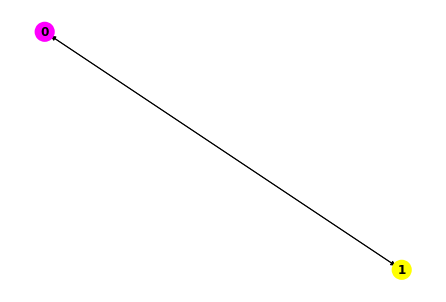

In [174]:
plt.figure() 
graph = dataset[15]
print(graph)
print("Node features:", graph.node_feature[0])
if graph.graph_label == 0:
    print("Neutral pion")
elif graph.graph_label == 1:
    print("Charged pion")
print("Class:", graph.graph_label[0])
nx.draw(to_networkx(graph), 
        cmap='spring', 
        with_labels=True,
        font_weight='bold',
        node_color = np.arange(graph.num_nodes),
        node_size=200, linewidths=6)

Visualize a bunch of these (not too interesting with only two nodes, but you get the idea):

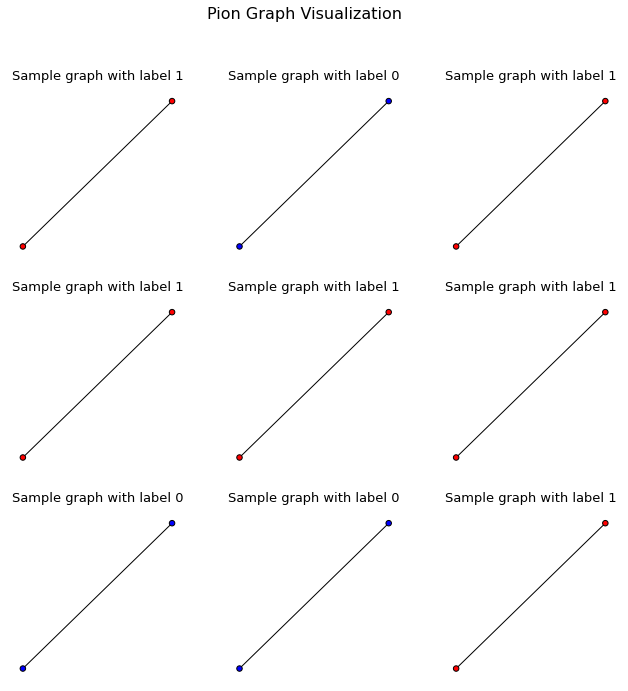

In [155]:
def visualize(dataset):
    color_mapping = {
        0 : 'blue',
        1 : 'red',
    }
    num_graphs_i = 3
    num_graphs_j = 3
    fig, ax = plt.subplots(num_graphs_i, num_graphs_j, figsize=(11, 11))
    fig.suptitle("Pion Graph Visualization", fontsize=16)
    indices = np.random.choice(np.arange(0, len(dataset)), size=9, replace=False)
    indices = indices.reshape(3, 3)
    for i in range(num_graphs_i):
        for j in range(num_graphs_j):
            index = int(indices[i, j])
            G = dataset[index].G
            label = dataset[index].graph_label.item()
            pos = nx.spring_layout(G, seed=1)
            colors = [color_mapping[label]] * dataset[index].num_nodes
            nodes = nx.draw_networkx_nodes(G, pos=pos, cmap=plt.get_cmap('coolwarm'), \
                node_size=30, ax=ax[(i, j)], node_color=colors)
            nodes.set_edgecolor('black')
            nx.draw_networkx_edges(G, pos=pos, ax=ax[(i, j)])
            ax[(i, j)].set_title("Sample graph with label {}".format(label), fontsize=13)
            ax[(i, j)].set_axis_off()
    plt.show()
visualize(dataset)

We'll use the same architecture as the multi-class classifier we defined earlier for the ENZYMES dataset, except now the number of classes/node features/etc. are a little different.

In [156]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, device="cpu"):
    model = GNNClassifier(num_node_features, args["hidden_size"], num_classes, args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    best_model = None
    max_val = -1
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        num_graphs = 0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.graph_label
            loss = model.loss(pred, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            num_graphs += batch.num_graphs
        total_loss /= num_graphs
        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        if val_acc > max_val:
            max_val = val_acc
            best_model = deepcopy(model)
        test_acc = test(test_loader, model, device)
        log = "Epoch {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}"
        print(log.format(epoch + 1, train_acc, val_acc, test_acc, total_loss))
    return best_model

def test(loader, model, device='cuda'):
    model.eval()
    correct = 0
    num_graphs = 0
    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            label = batch.graph_label
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
    return correct / num_graphs

In [157]:
args = {
    "device" : 'cpu', # 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 50,
    "epochs" : 10,
    "lr" : 0.001,
    "num_layers": 3,
    "batch_size": 32,
}

dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1])

num_node_features = 3
num_classes = dataset.num_graph_labels

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])

best_model = train(train_loader, val_loader, test_loader, args, 
                   num_node_features, num_classes, args["device"])

train_acc = test(train_loader, best_model, args["device"])
val_acc = test(val_loader, best_model, args["device"])
test_acc = test(test_loader, best_model, args["device"])
log = "Best model: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}"
print(log.format(train_acc, val_acc, test_acc))

Epoch 1: Train: 0.9386, Validation: 0.9317. Test: 0.9347, Loss: 0.2254
Epoch 2: Train: 0.9446, Validation: 0.9377. Test: 0.9420, Loss: 0.1954
Epoch 3: Train: 0.9468, Validation: 0.9468. Test: 0.9450, Loss: 0.1859
Epoch 4: Train: 0.9462, Validation: 0.9407. Test: 0.9414, Loss: 0.1832
Epoch 5: Train: 0.9450, Validation: 0.9389. Test: 0.9420, Loss: 0.1810
Epoch 6: Train: 0.9457, Validation: 0.9444. Test: 0.9414, Loss: 0.1800
Epoch 7: Train: 0.9333, Validation: 0.9287. Test: 0.9293, Loss: 0.1796
Epoch 8: Train: 0.9415, Validation: 0.9341. Test: 0.9426, Loss: 0.1768
Epoch 9: Train: 0.9419, Validation: 0.9299. Test: 0.9390, Loss: 0.1744
Epoch 10: Train: 0.9405, Validation: 0.9389. Test: 0.9378, Loss: 0.1717
Best model: Train: 0.9468, Validation: 0.9468. Test: 0.9450


In [158]:
test_acc = test_with_printouts(test_loader, best_model, args["device"])

====== BATCH 0 ======
Predicted labels: tensor([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 0])
True labels: tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 1])
Total graphs in batch: 32
Number correctly predicted: 29
Accuracy = 90.62%
====== BATCH 1 ======
Predicted labels: tensor([1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 0])
True labels: tensor([1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 0, 0])
Total graphs in batch: 32
Number correctly predicted: 32
Accuracy = 100.00%
====== BATCH 2 ======
Predicted labels: tensor([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 1])
True labels: tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 1, 1])
Total graphs

### &rarr; Before moving onto the next section:
Can you add another node to each graph representing the sub-leading cluster energy?

# Pion regression

The goal in this section is to correctly predict the truth pion energy based on the cell-level energies for each pion topo-cluster as well as the leading track information. This graph is much more exciting, since it is constructed from as many nodes as there are calorimeter cells with energy deposits > 0.5 GeV! Plus one additional node for the track information. The global feature is the total cluster energy. The regression target is the truth pion energy. 

In [176]:
### Load data (multiple files)
n_files = 2
pion_files = glob.glob("../data/onetrack_multicluster/pion_files/*.npy")
df_pion = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(pion_files[:n_files])])
print("Pion dataframe has {:,} events.".format(df_pion.shape[0]))

100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

Pion dataframe has 20,550 events.


In [177]:
def clean_dataframe(df): 
    ### Start the dataframe of inputs 
    max_n_cols = pd.DataFrame(df.cluster_E.to_list()).shape[1]
    df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(max_n_cols)]))
    
    df3 = pd.DataFrame(pd.DataFrame(df.cluster_Eta.to_list(), columns=["cluster_eta_"+str(x) for x in np.arange(max_n_cols)]))
    df2['cluster_eta_0'] = df3['cluster_eta_0'] 
    
    df3 = pd.DataFrame(pd.DataFrame(df.cluster_Phi.to_list(), columns=["cluster_phi_"+str(x) for x in np.arange(max_n_cols)]))
    df2['cluster_phi_0'] = df3['cluster_phi_0']   
    
    ### Add cluster cell energy
    cluster_cell_e = []
    for i in range(len(df2)): 
        cluster_cell_e.append(np.array(np.log10(df.cluster_cell_E.iloc[i][0]))) # only cells from leading cluster
    df3["cluster_cell_e"] = cluster_cell_e
    max_n_cells = pd.DataFrame(df3.cluster_cell_e.to_list()).shape[1]
    df_cells = pd.DataFrame(pd.DataFrame(df3.cluster_cell_e.to_list(), columns=["cluster_cell_e_"+str(x) for x in np.arange(max_n_cells)]))
    df2 = pd.concat([df2, df_cells], axis="columns")
    
    ### Add track pT & truth particle E 
    track_pt = np.array(df.trackPt.explode())
    truth_particle_e = np.array(df.truthPartE.explode())
    track_eta = np.array(df.trackEta.explode())
    track_phi = np.array(df.trackPhi.explode())
    track_z0 = np.array(df.trackZ0.explode())

    df2["track_pt"] = track_pt
    df2["track_eta"] = track_eta
    df2["track_phi"] = track_phi
    df2["track_z0"] = track_z0
    df2["truth_particle_e"] = truth_particle_e
        
    ### Cluster_E > 0.5
    df2 = df2[df2.cluster_e_0 > 0.5]

    ### Lose outliers in track pT 
    df2 = df2[df2.track_pt < 5000]
    
    ### Cast as float
    df2 = df2.astype('float32')

    ### Add the log of all energy variables
    for var in df2.keys():
        if var in ["track_eta", "track_phi", "track_z0", "cluster_cell_e", "cluster_eta", "cluster_phi"]:
            continue
        elif "cell" in var:
            continue
        else:
            df2['log10_'+var] = np.log10(df2[var])

    ### Drop infs/NaNs 
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df2 = df2.fillna(0)
    
    ### Reduce variables
    vars = [
    'log10_cluster_e_0', 
    'log10_track_pt',
    'track_eta', 
    'track_phi',
    'track_z0',
    'log10_truth_particle_e',
    'cluster_eta_0',
    'cluster_phi_0',
             ]
    
    vars += [var for var in df2.keys() if "cell" in var]
    
    df2 = df2[vars]
    
    ### Standardize inputs
    sc = StandardScaler()
    x = df2.values
    x = sc.fit_transform(x)
    
    for i in range(len(vars)):
        df2[vars[i]+"_scaled"] = x[:,i]
        
    df2['num_cells_lead_cluster'] = np.sum(df2[[var for var in df2.keys() if "scaled" not in var and "cell" in var]] != 0, axis=1)
        
    ### Get rid of any duplicate target values
    df2.reset_index(drop=True, inplace=True)
    series = df2.log10_truth_particle_e_scaled
    indices_to_drop = series[series.duplicated()].index
    df2.drop(indices_to_drop, inplace=True)
    df2.reset_index(drop=True, inplace=True)

    return df2

In [226]:
### This will create a bunch of warnings that you can ignore for the purposes of this tutorial
df = clean_dataframe(df_pion)

/clusterfs/ml4hep/mpettee/miniconda3/envs/pytorch_geo/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/clusterfs/ml4hep/mpettee/miniconda3/envs/pytorch_geo/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_16357/2983635687.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2[vars[i]+"_scaled"] = x[:,i]
/tmp/ipykernel_16357/2983635687.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

Let's inspect the dataframe we just assembled:

In [227]:
df

,log10_cluster_e_0,log10_track_pt,track_eta,track_phi,track_z0,log10_truth_particle_e,cluster_eta_0,cluster_phi_0,cluster_cell_e_0,cluster_cell_e_1,...,cluster_cell_e_684_scaled,cluster_cell_e_685_scaled,cluster_cell_e_686_scaled,cluster_cell_e_687_scaled,cluster_cell_e_688_scaled,cluster_cell_e_689_scaled,cluster_cell_e_690_scaled,cluster_cell_e_691_scaled,cluster_cell_e_692_scaled,num_cells_lead_cluster
0,2.733134,2.755852,-0.046391,0.052152,-51.260349,2.856531,-0.046795,0.049620,2.624998,0.853044,...,0.012579,0.01405,0.01404,0.013437,0.013018,0.011839,0.009974,0.009937,0.007059,72
1,0.532984,0.829245,0.250689,-0.004633,-23.837978,0.844007,0.246360,-0.068763,-0.181157,-0.330833,...,0.012579,0.01405,0.01404,0.013437,0.013018,0.011839,0.009974,0.009937,0.007059,46
2,2.449312,2.230702,-1.919379,2.418486,-59.106083,2.795255,-1.934480,2.413878,1.709740,1.150420,...,0.012579,0.01405,0.01404,0.013437,0.013018,0.011839,0.009974,0.009937,0.007059,176
3,1.436833,1.574001,-0.850665,-0.479902,-41.752960,1.701718,-0.856242,-0.522446,0.695749,-0.309854,...,0.012579,0.01405,0.01404,0.013437,0.013018,0.011839,0.009974,0.009937,0.007059,88
4,2.246385,1.939543,1.654420,1.151863,69.096138,2.367431,1.670262,1.147337,1.586761,0.979798,...,0.012579,0.01405,0.01404,0.013437,0.013018,0.011839,0.009974,0.009937,0.007059,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20055,1.036740,1.356646,-0.265961,2.652140,-33.089409,1.377262,-0.266402,2.617359,0.891653,-0.280536,...,0.012579,0.01405,0.01404,0.013437,0.013018,0.011839,0.009974,0.009937,0.007059,48
20056,3.120596,2.351865,-0.639932,0.847341,32.405289,3.221821,-0.625801,0.844030,2.071080,1.561556,...,0.012579,0.01405,0.01404,0.013437,0.013018,0.011839,0.009974,0.009937,0.007059,503
20057,0.760996,0.481424,2.383007,-0.483378,3.711866,1.177474,2.371992,-0.534355,0.167647,-0.111671,...,0.012579,0.01405,0.01404,0.013437,0.013018,0.011839,0.009974,0.009937,0.007059,29
20058,1.469862,1.713296,0.456868,2.191851,55.743259,1.773140,0.467485,2.207323,0.352573,-1.610292,...,0.012579,0.01405,0.01404,0.013437,0.013018,0.011839,0.009974,0.009937,0.007059,64


And now we'll convert the dataframe into a graph structure:

In [228]:
class PionDataset_Regress(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dataframe, cluster_features, track_features):
        'Initialization'
        self.dataframe = dataframe
        self.cluster_features = cluster_features
        self.track_features = track_features
        print("")

    def __len__(self):
        'Denotes the total number of samples'
        dataframe = self.dataframe
        return len(dataframe)

    def __getitem__(self, index):
        'Generates one sample of data'  
        dataframe = self.dataframe
        
        ### define nodes with topo-cluster CELL energies! 
        cell_info = ['cluster_cell_e_'+str(i)+'_scaled' for i in range(int(dataframe.iloc[index].num_cells_lead_cluster))]
        cluster_nodes = np.zeros((int(dataframe.iloc[index].num_cells_lead_cluster), 1+len(cluster_features)+len(track_features)))
        cluster_nodes[:,0] = dataframe.iloc[index][cell_info]
        
        cluster_global_node = np.array(dataframe.iloc[index][cluster_features])
        cluster_global_node = np.concatenate([np.zeros(1), cluster_global_node, np.zeros(len(track_features))]) # cluster features come first
        
        track_node = np.array(dataframe.iloc[index][track_features])
        track_node = np.concatenate([np.zeros(len(cluster_features)+1), track_node]) # cluster features come first
        
        # shape = (num_nodes, num_node_features) = (2, 3)
        nodes = np.vstack([cluster_nodes, cluster_global_node, track_node]) 
        
        ### define edges (fully-connected, but no self-loops)
        edges = [(i,j) for i in range(nodes.shape[0]) for j in range(nodes.shape[0]) if i != j]
        edges_reversed = [(i,j) for i in range(nodes.shape[0]) for j in range(nodes.shape[0]) if i != j]
        edge_index = np.row_stack([edges,edges_reversed])
        
        ### Define regression target 
        target = np.array([dataframe.iloc[index]['log10_truth_particle_e']])
        
        # Convert to torch objects
        nodes = torch.Tensor(nodes)
        edge_index = torch.tensor(edge_index, dtype=torch.long)
        target = torch.tensor(target)
        
        return Data(x=nodes, y=target, edge_index=edge_index.t().contiguous()  )

Actually create the pion graphs -- this can take some time, so try it with a limited number of events first just to test things:

In [205]:
%%time 

n_events = 100 ### Testing
# n_events = len(df) ### Full dataset

cluster_features = ['log10_cluster_e_0_scaled']
track_features = ['log10_track_pt_scaled', 'track_eta_scaled', 'track_phi_scaled', 'track_z0_scaled']
pions = PionDataset_Regress(df[:n_events], cluster_features, track_features)
graphs = GraphDataset.pyg_to_graphs(pions) 
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
print(len(dataset))
print("Dataset has {} node features".format(dataset.num_node_features))


100
Dataset has 6 node features
CPU times: user 2min 11s, sys: 3.4 s, total: 2min 15s
Wall time: 12.8 s


Graph(G=[], edge_index=[2, 5402], edge_label_index=[2, 5402], graph_label=[1], node_feature=[74, 6], node_label_index=[74], task=[])
Node features: tensor([[ 1.7756,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.7530,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.7167,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.1825,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.6056,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.7070,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1209,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.7896,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.3614,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.6818,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.3885,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 2.3775,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.9792,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.2799,  0

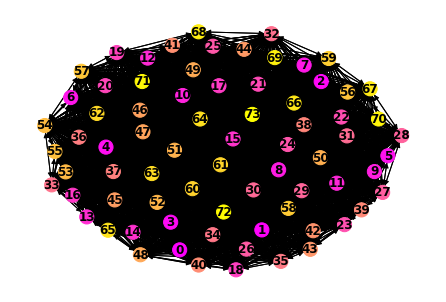

In [206]:
plt.figure() 
graph = dataset[0]
print(graph)
print("Node features:", graph.node_feature) # cluster_cell_e, log10_cluster_e_0, log10_track_pt, track_eta, track_phi, track_z0 (all scaled)
print("Regression target", graph.graph_label)
nx.draw(to_networkx(graph), 
        cmap='spring', 
        with_labels=True,
        font_weight='bold',
        node_color = np.arange(graph.num_nodes),
        node_size=200, linewidths=1)

In [207]:
class GNNRegression(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GNNRegression, self).__init__()
        self.num_layers = args["num_layers"]
        self.pre_mp = nn.Linear(input_size, hidden_size)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for l in range(self.num_layers):
            layer = Sequential(
                Linear(hidden_size, hidden_size), 
                nn.ReLU(), 
                Linear(hidden_size, hidden_size)
            )
            self.convs.append(GINConv(layer))
            self.bns.append(nn.BatchNorm1d(hidden_size))
        self.post_mp = Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(), 
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch
        x = self.pre_mp(x)
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
        x = self.convs[-1](x, edge_index)
        x = pyg_nn.global_mean_pool(x, batch) ### Now use mean instead of sum
        x = self.post_mp(x)
        return x

    def loss(self, pred, target):
        pred = pred.reshape(pred.shape[0])
        return F.mse_loss(pred, target) ### Mean squared error loss now, for regression

In [215]:
def train(train_loader, val_loader, test_loader, args, num_node_features, output_size, device="cpu"):
    model = GNNRegression(num_node_features, args["hidden_size"], 1, args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    best_model = None
    max_val = -1
    for epoch in range(args["epochs"]):
        t0 = time.time() 
        total_loss = 0
        model.train()
        num_graphs = 0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            target = batch.graph_label
            loss = model.loss(pred.float(), target.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            num_graphs += batch.num_graphs
        total_loss /= num_graphs
        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        if val_acc > max_val:
            max_val = val_acc
            best_model = deepcopy(model)
        test_acc = test(test_loader, model, device)
        log = "Epoch {} (took {:.2f} seconds): Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}"
        print(log.format(epoch + 1, time.time() - t0, train_acc, val_acc, test_acc, total_loss))
    return best_model

def test(loader, model, device='cuda'):
    model.eval()
    ratio = []
    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = model(batch)[:,0] # to make the shapes match
            target = batch.graph_label
            ratio.append(torch.median(torch.divide(pred, target))) 
    return np.mean(np.array(ratio))

def test_after_training(loader, model, device='cuda'):
    model.eval()
    preds = []
    targets = []
    ratio = []
    batch_num = 0
    for batch in loader:
        print("====== BATCH {} ======".format(batch_num))
        batch.to(device)
        with torch.no_grad():
            pred = model(batch)[:,0] # to make the shapes match
            preds.append(pred)
            print("Predicted energies:", pred)
            target = batch.graph_label
            targets.append(target)
            print("Truth energies:", target)
            print("Ratios:", torch.divide(pred, target))
        ratio.append(torch.median(torch.divide(pred, target))) 
        batch_num += 1
        print("Median ratio per batch: {}".format(torch.median(torch.divide(pred, target))))
    preds_reshaped = torch.cat([torch.stack(preds).view(-1, 1)])
    targets_reshaped = torch.cat([torch.stack(targets).view(-1, 1)])
    return np.median(np.array(ratio)), preds_reshaped, targets_reshaped

In [216]:
args = {
    "device" : 'cpu', #'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 10,
    "epochs" : 10,
    "lr" : 0.001,
    "num_layers": 3,
    "batch_size": 10,
}

dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1])

num_node_features = len(cluster_features)+len(track_features)+1

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])

best_model = train(train_loader, val_loader, test_loader, args, 
                   num_node_features, 1, args["device"])

train_acc = test(train_loader, best_model, args["device"])
val_acc = test(val_loader, best_model, args["device"])
test_acc = test(test_loader, best_model, args["device"])

# Values printed are best median ratio of predicted energy to target:
log = "Best model: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}"
print(log.format(train_acc, val_acc, test_acc))

Epoch 1 (took 1.04 seconds): Train: 0.4423, Validation: 0.5003. Test: 0.7087, Loss: 3.6232
Epoch 2 (took 1.00 seconds): Train: 0.6869, Validation: 0.7071. Test: 0.8698, Loss: 2.4736
Epoch 3 (took 1.02 seconds): Train: 0.6429, Validation: 0.5998. Test: 0.8245, Loss: 1.2657
Epoch 4 (took 0.95 seconds): Train: 0.6254, Validation: 0.5934. Test: 0.7894, Loss: 1.6985
Epoch 5 (took 0.98 seconds): Train: 0.6372, Validation: 0.5942. Test: 0.8220, Loss: 0.8275
Epoch 6 (took 0.94 seconds): Train: 0.6684, Validation: 0.6041. Test: 0.8632, Loss: 0.9939
Epoch 7 (took 0.95 seconds): Train: 0.7443, Validation: 0.6368. Test: 0.9108, Loss: 0.8736
Epoch 8 (took 0.97 seconds): Train: 0.7973, Validation: 0.6910. Test: 0.9654, Loss: 0.7642
Epoch 9 (took 0.97 seconds): Train: 0.7497, Validation: 0.7579. Test: 0.9692, Loss: 1.1488
Epoch 10 (took 0.96 seconds): Train: 0.7698, Validation: 0.7816. Test: 1.0451, Loss: 1.1067
Best model: Train: 0.7793, Validation: 0.7816. Test: 1.0451


#### Make plots to evaluate performance:

We ideally want the median ratio to be close to 1:

In [218]:
median_ratio, preds, targets = test_after_training(test_loader, best_model, args["device"])

====== BATCH 0 ======
Predicted energies: tensor([1.4695, 1.8919, 1.0290, 1.4706, 4.6236, 2.5397, 2.4829, 1.9415, 1.7561,
        0.8211])
Truth energies: tensor([1.4060, 1.7440, 0.8440, 2.0945, 2.8927, 3.0369, 2.7953, 1.7577, 1.4874,
        0.8703], dtype=torch.float64)
Ratios: tensor([1.0451, 1.0848, 1.2191, 0.7021, 1.5984, 0.8363, 0.8882, 1.1046, 1.1806,
        0.9436], dtype=torch.float64)
Median ratio per batch: 1.0451221910969728


In [219]:
test_df = df.loc[df['log10_truth_particle_e'].isin(np.array(targets[:,0]))]
test_df = test_df.sort_values('log10_truth_particle_e')

nn_outputs = pd.DataFrame(np.vstack([np.array(preds[:,0]), np.array(targets[:,0])]).T,
             columns = ["preds", "targets"])
nn_outputs = nn_outputs.sort_values('targets')

test_df["nn_preds"] = np.array(nn_outputs.preds)
test_df["nn_targets"] = np.array(nn_outputs.targets)

test_df[['nn_preds', 'nn_targets']] ### a well-trained model means that these will be similar!

,nn_preds,nn_targets
1,1.028956,0.844007
34,0.821143,0.870254
55,1.469474,1.406031
90,1.756077,1.487390
22,1.891898,1.743999
25,1.941516,1.757672
59,1.470551,2.094459
2,2.482874,2.795255
17,4.623578,2.892703
85,2.539674,3.036903


Ideally, this should be a Gaussian distribution centered around 1. On a limited training dataset, though, we don't expect good performance:

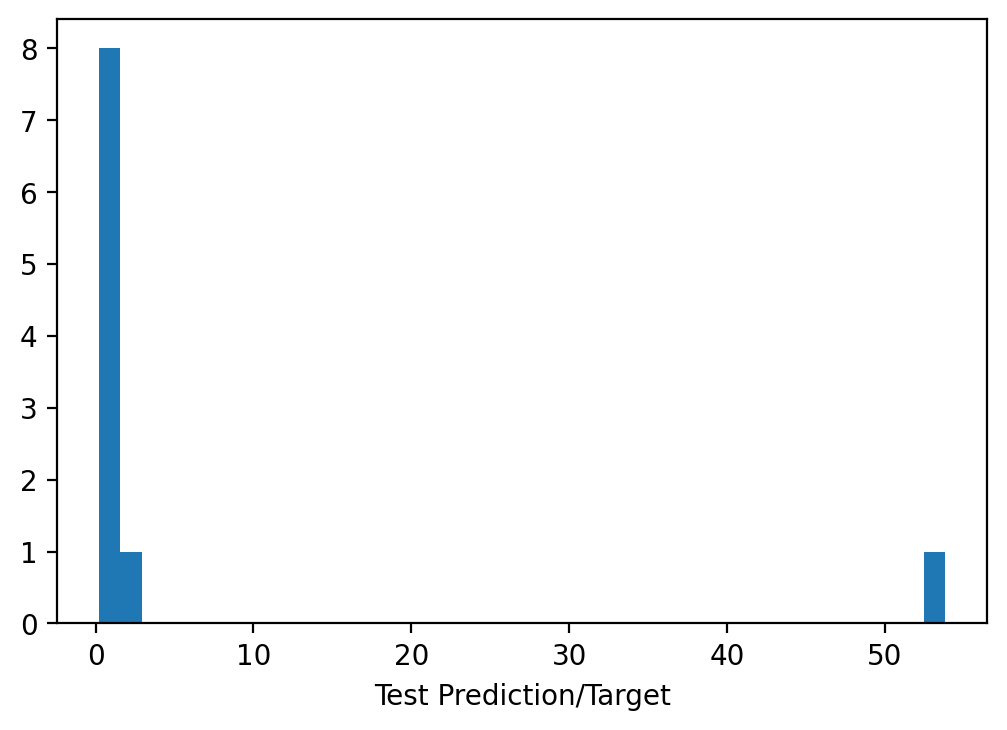

In [222]:
plt.figure(dpi=200)
plt.hist(10**test_df.nn_preds/10**test_df.nn_targets, 
         bins=40
         # bins=np.linspace(0.,2,40)
        );
plt.xlabel("Test Prediction/Target");

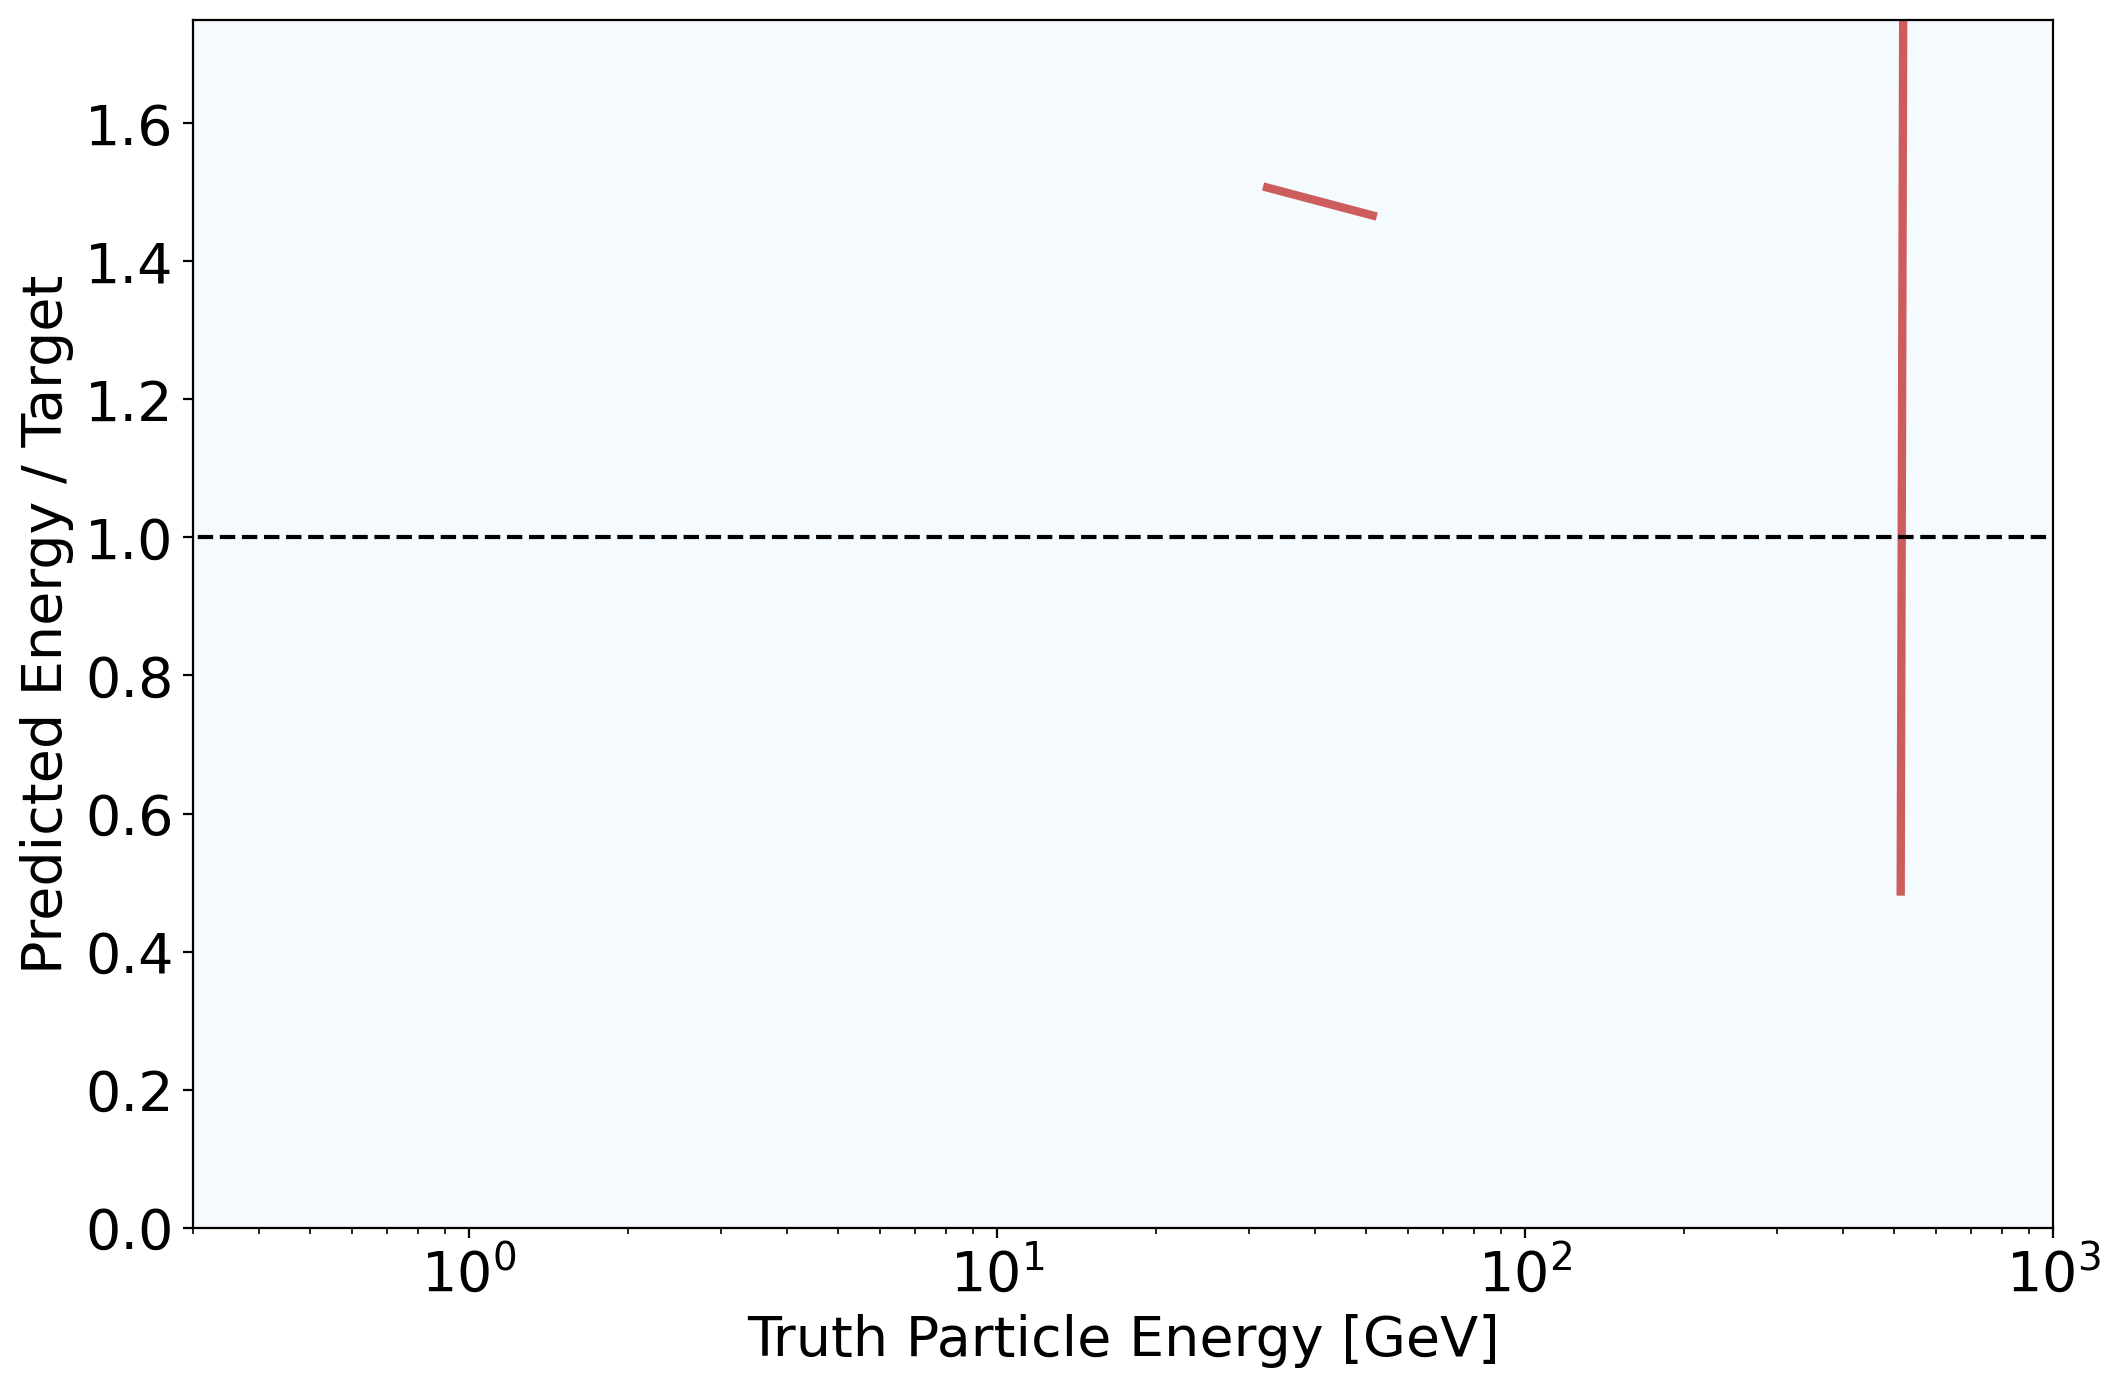

In [223]:
### Response median plot = a measure of the accuracy of energy predictions
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

x = 10**test_df.log10_truth_particle_e
y = 10**test_df.nn_preds/10**test_df.nn_targets

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.2)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
profileXMed = stats.binned_statistic(
    x, y, bins=xbin, statistic='median').statistic

c_map = ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())
fig = plt.figure(figsize=(12,8), dpi=200)
fig.patch.set_facecolor('white')
plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);
plt.plot(np.array(xcenter), np.array(profileXMed), color='indianred', linewidth=3)
plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black');
plt.xscale('log')
plt.ylim(0, 1.75)
plt.xlim(0.3, )
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Truth Particle Energy [GeV]', fontsize=20)
plt.ylabel('Predicted Energy / Target', fontsize=20);

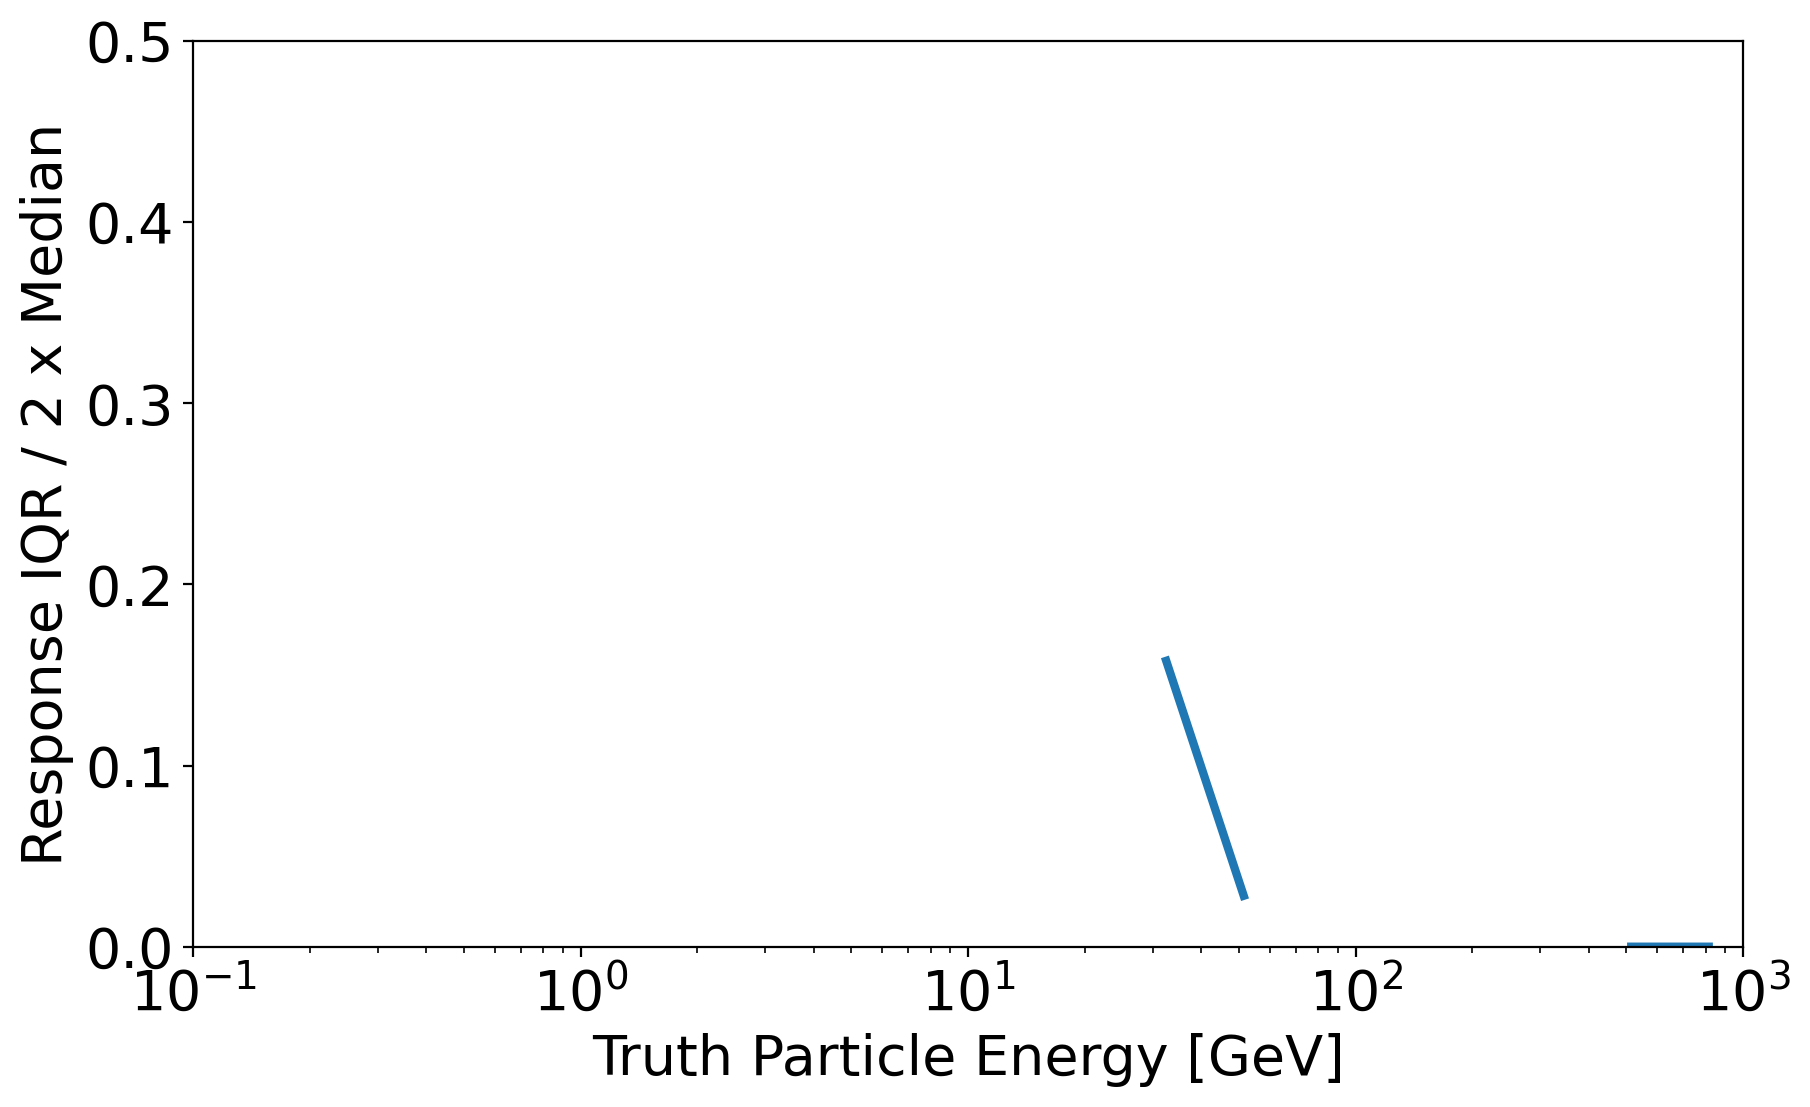

In [225]:
### IQR plot = a measure of the spread/precision of energy predictions

def iqrOverMed(x):
    # get the IQR = interquantile range via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q84, q16 = np.percentile(x, [84, 16])
    iqr = q84 - q16
    med = np.median(x)
    return iqr / (2*med)

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.2)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

resolution = stats.binned_statistic(x, y, bins=xbin,statistic=iqrOverMed).statistic

fig = plt.figure(figsize=(10,6), dpi=200)
fig.patch.set_facecolor('white')
plt.plot(xcenter, resolution, linewidth=3)
plt.xscale('log')
plt.xlim(0.1, 1000)
plt.ylim(0,0.5)
plt.xlabel('Truth Particle Energy [GeV]', fontsize=20);
plt.ylabel('Response IQR / 2 x Median', fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);

### &rarr; Before wrapping up this tutorial:
Go back and try generating graphs for more events, or the whole dataframe, and redoing the training to start seeing improved performance. You can also load in more pion files to increase the size of your training dataset.

Bonus points -- does it matter if you include the track information as an additional node or as a global feature?